In [3]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data.dataset import ConcatDataset

import time
import os
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

BATCH_SIZE = 64
TEST_SIZE = 0.1

ROOT_PATH = '/kaggle/input/data-for-proj/dataset_by_classes'

cuda:0
Tesla P100-PCIE-16GB


In [2]:
torch.cuda.empty_cache()

In [3]:
train_tfms = transforms.Compose([transforms.Resize((224, 224)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_affine = transforms.Compose([transforms.Resize((224, 224)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomAffine(degrees=(15, 40),translate=(0.1, 0.3), 
                                                         scale=(0.6, 0.8)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.4710, 0.4602, 0.4549],
                                                      std=[0.2668, 0.2659, 0.2710])])

train_clean = transforms.Compose([transforms.Resize((224, 224)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_tfms = torchvision.datasets.ImageFolder(root=ROOT_PATH, transform = train_tfms)
dataset_affine = torchvision.datasets.ImageFolder(root=ROOT_PATH, transform = train_affine)
dataset_train = torchvision.datasets.ImageFolder(root=ROOT_PATH, transform = train_clean)

dataset = ConcatDataset([dataset_tfms, dataset_train, dataset_affine])

In [4]:
test_len = int(TEST_SIZE*len(dataset))

train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-test_len, test_len])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_set),len(test_set))

18865 2096


Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])


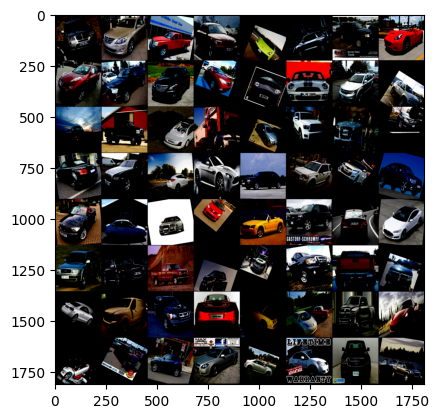

In [5]:
def imshow(img):
    img_np = img.cpu().numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print("Image batch dimensions:", images.shape)
print("Image label dimensions:", labels.shape)

In [6]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/BATCH_SIZE*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

    

In [7]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

# Model ResNet50

In [8]:
from torchvision.models import ResNet50_Weights

model_ft = models.resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [01:39<00:00, 1.03MB/s]


In [26]:
# for param in model_ft.parameters():
#     param.requires_grad = False

In [27]:
# for param in model_ft.layer3.parameters():
#     param.requires_grad = True

# for param in model_ft.layer2.parameters():
#     param.requires_grad = True

In [9]:
num_ftrs = model_ft.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=1e-6)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [10]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
for name, param in model_ft.named_parameters():
    if param.requires_grad:
        print (name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [12]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=15)

Epoch 1, duration: 309 s, loss: 3.0415, acc: 29.9311
Accuracy of the network on the test images: 43 %
Epoch 2, duration: 259 s, loss: 0.9493, acc: 72.1716
Accuracy of the network on the test images: 69 %
Epoch 3, duration: 256 s, loss: 0.4751, acc: 85.8369
Accuracy of the network on the test images: 77 %
Epoch 4, duration: 258 s, loss: 0.3028, acc: 90.8210
Accuracy of the network on the test images: 85 %
Epoch 5, duration: 258 s, loss: 0.2257, acc: 93.0403
Accuracy of the network on the test images: 86 %
Epoch 6, duration: 258 s, loss: 0.1812, acc: 94.5233
Accuracy of the network on the test images: 88 %
Epoch 7, duration: 259 s, loss: 0.1521, acc: 95.3602
Accuracy of the network on the test images: 91 %
Epoch 8, duration: 258 s, loss: 0.1258, acc: 96.3506
Accuracy of the network on the test images: 90 %
Epoch 9, duration: 254 s, loss: 0.0438, acc: 98.8347
Accuracy of the network on the test images: 96 %
Epoch 10, duration: 253 s, loss: 0.0214, acc: 99.3750
Accuracy of the network on t

# InceptionV3

In [8]:
model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 270MB/s] 


In [9]:
num_ftrs = model_ft.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=1e-6)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Text(0.5, 1.0, 'Test acc')

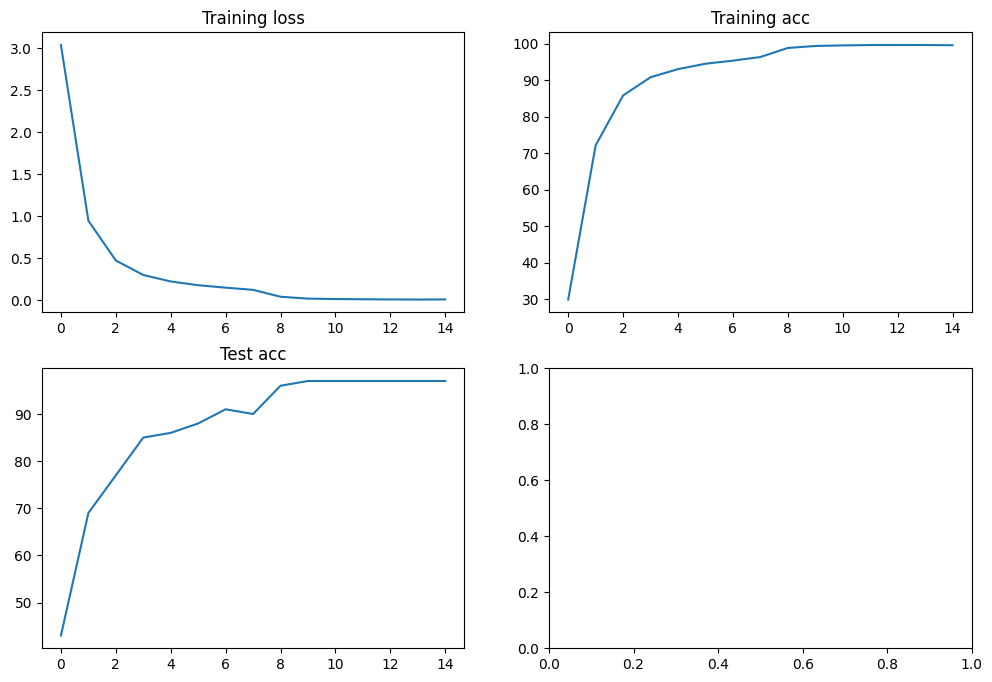

In [4]:
# plot the stats

training_losses = [3.0415, 0.9493, 0.4751, 0.3028, 0.2257, 0.1812, 0.1521, 0.1258, 0.0438, 0.0214, 0.0164, 0.0139, 0.0118, 0.0104, 0.0119]
training_accs = [29.9311, 72.1716, 85.8369, 90.8210, 93.0403, 94.5233, 95.3602, 96.3506, 98.8347, 99.3750, 99.5339, 99.6398, 99.6398, 99.6451, 99.5869]
test_accs = [43, 69, 77, 85, 86, 88, 91, 90, 96, 97, 97, 97, 97 ,97 ,97]

f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)

axarr[1, 0].set_title("Test acc")

Save model

In [14]:
def save_model(model, path, name):
  model_scripted = torch.jit.script(model)
  model_scripted.save(path + name)

In [15]:
save_model(model_ft, './', 'net_resnet50_15epochs_64batch_test0-1.pt')